In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statistics
import scipy.stats
from sklearn.model_selection import train_test_split

In [2]:
# φόρτωση δεδομένων
ded=pd.read_excel('CogTEL_new.xlsx')

In [3]:
# μετατροπή αλφαριθμητικών σε float και παράλληλα μετατροπή "-" σε NaN
ded['education']=pd.to_numeric(ded['education'],errors='coerce')
ded['GDS_6']=pd.to_numeric(ded['GDS_6'],errors='coerce')
ded['GDS_8']=pd.to_numeric(ded['GDS_8'],errors='coerce')
ded['GDS_9']=pd.to_numeric(ded['GDS_9'],errors='coerce')
ded['NPIJ32F']=pd.to_numeric(ded['NPIJ32F'],errors='coerce')

In [4]:
# για να μπορώ να εξάγω τις συγκεκριμένες στήλες (αχρείαστο βήμα...)
ded = ded.rename(columns={'Antidepressants ': 'Antidepressants' })
ded = ded.rename(columns={'Concentration/attention' : 'Concentration_attention'})

In [5]:
# αφαίρεση στιγμιοτύπων με missing values
ded=ded.dropna()

In [6]:
# αφαίρεση των παραδειγμάτων ηλικίας 50 και κάτω
dedomena=ded[ded['Age']>49]

In [7]:
# ανάθεση του συνόλου των ανεξάρτητων μεταβλητών και της μεταβλητής στόχου σε Χ και Υ
X=dedomena.drop('diagnosis',axis=1)
Y=dedomena.diagnosis

In [8]:
!pip install imblearn
!pip install imbalanced-learn

Class=0, n=208 (25.000%)
Class=2, n=208 (25.000%)
Class=1, n=208 (25.000%)
Class=3, n=208 (25.000%)


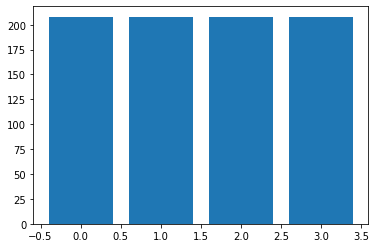

In [9]:
# τεχνική υπερδειγματοληψίας SMOTE 
from imblearn.over_sampling import SMOTE
from collections import Counter
oversample = SMOTE(random_state=7)
X, Y = oversample.fit_resample(X, Y)
# summarize distribution
counter = Counter(Y)
for k,v in counter.items():
    per = v / len(Y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()


In [10]:
# διαχωρισμός δεδομένων σε train και test set (μέθοδος hold-out)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=3)

In [11]:
!pip install xgboost
import xgboost as xgb
from sklearn.metrics import accuracy_score


In [12]:
model = xgb.XGBClassifier(random_state=45)
model.fit(X_train, Y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.40%


In [13]:
model.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=45, reg_alpha=0, ...)>

In [14]:
from sklearn.metrics import classification_report
print("Classification Report")
print(classification_report(Y_test, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        69
           1       0.76      0.75      0.76        69
           2       0.87      0.82      0.84        66
           3       0.75      0.93      0.83        46

    accuracy                           0.82       250
   macro avg       0.82      0.83      0.83       250
weighted avg       0.83      0.82      0.82       250



In [15]:
model.score(X_train,Y_train)

1.0

In [16]:
# Κάνουμε nested CV 
# aλλάζοντας το όρισμα scoring έχουμε τα αντίστοιχα αποτελέσματα για τις μετρικές precision_micro, recall_micro κτλ 
from sklearn.model_selection import GridSearchCV,cross_val_score,RepeatedKFold,KFold

clf1=xgb.XGBClassifier(random_state=6)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
space=dict()
space['learning_rate']=[0.1, 0.5, 0.7, 1]
space['n_estimators']=[100, 200, 300, 400]
search = GridSearchCV(clf1, space, scoring='recall_micro', n_jobs=-1, cv=inner_cv, refit=True)
search.fit(X, Y)

nested_scores=cross_val_score(search, X, Y, scoring='recall_micro',cv=outer_cv, n_jobs=-1)
nested_scores

array([0.90419162, 0.82634731, 0.85542169, 0.84939759, 0.89156627])

In [17]:
nested_scores.mean()

0.8653848928648727

In [18]:
search.best_params_

{'learning_rate': 0.1, 'n_estimators': 400}

# OVO και ΟVR (ή OVA)

In [19]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

In [20]:
xg_clf= OneVsOneClassifier(xgb.XGBClassifier(random_state=23))
xg_clf.fit(X_train, Y_train)

y_pred = xg_clf.predict(X_test)

print('Precision-micro of OvO Classifier: {:.2f}'.format(precision_score(Y_test, y_pred, average='micro')))
print('Recall-micro of OvO Classifier: {:.2f}'.format(recall_score(Y_test, y_pred, average='micro')))
print('f1-micro of OvO Classifier: {:.2f}'.format(f1_score(Y_test, y_pred, average='micro')))

Precision-micro of OvO Classifier: 0.80
Recall-micro of OvO Classifier: 0.80
f1-micro of OvO Classifier: 0.80


In [21]:
# nested cv για ΟVO
# aργεί πολύ
# για τον συντονισμό των υπερπαραμέτρων με τους ταξινομητές OVO και OVR χρησιμοποιείται το πρόθεμα 'estimator__' για κάθε υπερπαράμετρο που ελέγχουμε
clf=OneVsOneClassifier(xgb.XGBClassifier(random_state=6))
inner_cv = KFold(n_splits=5, shuffle= True, random_state=1)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)
space=dict()
space['estimator__learning_rate']=[0.1, 0.3, 1]
space['estimator__n_estimators']=[100, 200, 300, 500]
search = GridSearchCV(clf, space, scoring='f1_micro', n_jobs=-1, cv=inner_cv, refit=True)
search.fit(X, Y)

nested_scores=cross_val_score(search, X, Y, scoring='f1_micro', cv=outer_cv, n_jobs=-1,error_score="raise")
nested_scores

array([0.91666667, 0.88095238, 0.8313253 , 0.8313253 , 0.81927711,
       0.81927711, 0.80722892, 0.85542169, 0.86746988, 0.85542169])

In [22]:
nested_scores.mean()

0.8484366035570854

In [23]:
xg_clf = OneVsRestClassifier(xgb.XGBClassifier(random_state=9))
xg_clf.fit(X_train, Y_train)

y_pred = xg_clf.predict(X_test)

print('Precision-micro of OvR Classifier: {:.2f}'.format(precision_score(Y_test, y_pred, average='micro')))
print('Recall-micro of OvR Classifier: {:.2f}'.format(recall_score(Y_test, y_pred, average='micro')))
print('f1-micro of OvR Classifier: {:.2f}'.format(f1_score(Y_test, y_pred, average='micro')))

Precision-micro of OvR Classifier: 0.82
Recall-micro of OvR Classifier: 0.82
f1-micro of OvR Classifier: 0.82


In [24]:
# nested cv για ΟVR
# aργεί πολύ
# για τον συντονισμό των υπερπαραμέτρων με τους ταξινομητές OVO και OVR χρησιμοποιείται το πρόθεμα 'estimator__' για κάθε υπερπαράμετρο που ελέγχουμε
clf=OneVsOneClassifier(xgb.XGBClassifier(random_state=6))
inner_cv = KFold(n_splits=5, shuffle= True, random_state=1)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)
space=dict()
space['estimator__learning_rate']=[0.1, 0.3, 1]
space['estimator__n_estimators']=[100, 200, 300, 500]
search = GridSearchCV(clf, space, scoring='f1_micro', n_jobs=-1, cv=inner_cv, refit=True)
search.fit(X, Y)

nested_scores=cross_val_score(search, X, Y, scoring='f1_micro', cv=outer_cv, n_jobs=-1,error_score="raise")
nested_scores

array([0.91666667, 0.88095238, 0.8313253 , 0.8313253 , 0.81927711,
       0.81927711, 0.80722892, 0.85542169, 0.86746988, 0.85542169])

In [25]:
nested_scores.mean()

0.8484366035570854

In [26]:
xg_clf.estimators_

[XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_estimators=100,
               n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=9,
               reg_alpha=0, reg_lambda=1, ...),
 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
  

In [27]:
xg_clf.classes_


array([0, 1, 2, 3], dtype=int64)